In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

**FIND OPTIMAL K**

Text(0.5, 1.0, 'Elbow Method')

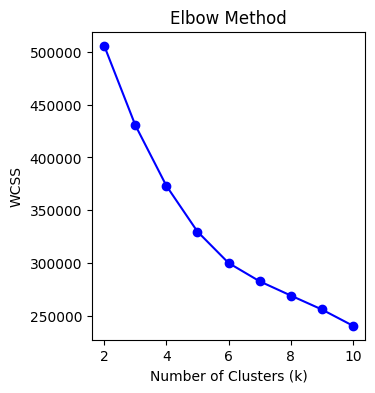

In [ ]:
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')

 **KMEANS** **with** **Optimal** **K**

In [ ]:
# Let's use k=4 based on your original code, or choose from elbow
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate silhouette score
sil_score = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score for k={optimal_k}: {sil_score:.3f}")

Silhouette Score for k=4: 0.223


**ISOLATION FOREST (Anomaly Detection)**

In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Is_Anomaly'] = iso_forest.fit_predict(X_scaled)
df['Is_Anomaly'] = df['Is_Anomaly'].map({1: 0, -1: 1})

print(f"Number of anomalies detected: {df['Is_Anomaly'].sum()}")
print(f"Anomaly percentage: {(df['Is_Anomaly'].sum() / len(df)) * 100:.2f}%")


Number of anomalies detected: 3290
Anomaly percentage: 5.00%


**VISUALIZATIONS**

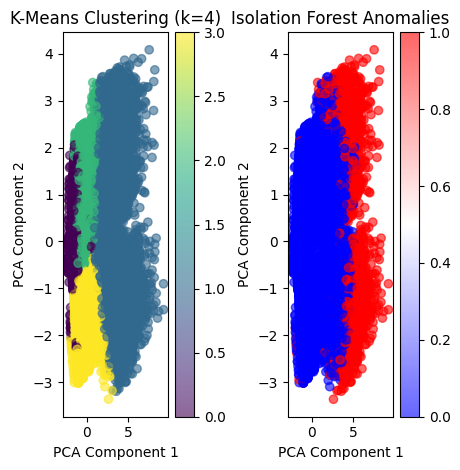

In [ ]:
# PCA for clustering visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot 1: Clusters
plt.subplot(1, 3, 2)
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-Means Clustering (k={optimal_k})')

# Plot 2: Anomalies
plt.subplot(1, 3, 3)
colors = ['blue', 'red']
scatter = plt.scatter(df['PCA1'], df['PCA2'], c=df['Is_Anomaly'], cmap='bwr', alpha=0.6)
plt.colorbar(scatter)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Isolation Forest Anomalies')

plt.tight_layout()
plt.show()

**CLUSTER ANALYSIS**

In [ ]:

print("CLUSTER PROFILES:")


cluster_summary = df.groupby('Cluster').agg({
    'Total_kWh_Monthly': 'mean',
    'Estimated_Bill_RWF': 'mean',
    'Household_Size': 'mean',
    'Income_Level_Encoded': 'mean',
    'Power_Watts': 'mean'
}).round(2)

print(cluster_summary)

CLUSTER PROFILES:
         Total_kWh_Monthly  Estimated_Bill_RWF  Household_Size  \
Cluster                                                          
0                    28.11             4584.20            5.04   
1                   698.05           250209.11            5.00   
2                   154.08            49489.44            4.92   
3                   126.07            39473.72            4.97   

         Income_Level_Encoded  Power_Watts  
Cluster                                     
0                        1.07        42.02  
1                        0.00       665.22  
2                        1.88        62.90  
3                        1.64       886.44  


**ANOMALY ANALYSIS**

In [ ]:

print("ANOMALY ANALYSIS:")

anomalies = df[df['Is_Anomaly'] == 1]
print(f"Top 10 anomalies by highest power consumption:")
print(anomalies.nlargest(10, 'Power_Watts')[['Appliance', 'Power_Watts', 'Total_kWh_Monthly', 'Estimated_Bill_RWF']])

ANOMALY ANALYSIS:
Top 10 anomalies by highest power consumption:
          Appliance  Power_Watts  Total_kWh_Monthly  Estimated_Bill_RWF
21184            AC         3000             721.50           258863.50
40536  Water Heater         3000             876.95           316224.55
42203            AC         2998            1416.03           515145.07
44344            AC         2998            1013.29           366534.01
58960            AC         2997             711.74           255262.06
31313  Water Heater         2993             943.01           340600.69
42054            AC         2993             764.50           274730.50
14057  Water Heater         2991             608.48           217159.12
59132            AC         2991            1627.45           593159.05
6030             AC         2990             942.88           340552.72
